In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(32 * 1 * 23, 128)
        self.fc2 = nn.Linear(128, encoded_space_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x, i_1 = self.pool1(self.conv2(x))
        x = F.relu(self.bn1(x))
        x, i_2 = self.pool2(self.conv3(x))
        x = F.relu(self.bn2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, i_1, i_2


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 128)
        self.fc2 = nn.Linear(128, 32 * 1 * 23)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 1, 23))

        self.deconv1 = nn.ConvTranspose2d(32, 16, 5, output_padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.unpool1 = nn.MaxUnpool2d(2)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, padding=1)
        
    def forward(self, x, unpool_i1, unpool_i2):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.unflatten(x)
        x = self.unpool1(x, unpool_i2)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = self.unpool2(x, unpool_i1)
        x = F.relu(self.bn2(self.deconv2(x)))
        x = self.deconv3(x)
        return x


class Classifier(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 16)
        self.fc2 = nn.Linear(16, 7)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1) #dim0=batch, dim1=element
        return x
    

class AutoEncoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder = Encoder(encoded_space_dim)
        self.decoder = Decoder(encoded_space_dim)
        self.classifier = Classifier(encoded_space_dim)
        
    def forward(self, x):
        feat, i_1, i_2 = self.encoder(x)
        pred_img = self.decoder(feat, i_1, i_2)
        pred_label = self.classifier(feat)
        return feat, pred_img, pred_label

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('trainset.pickle', 'rb') as file:
# with open('trainset.pickle', 'rb') as file:
    trainset = pickle.load(file)

spectrogram = torch.from_numpy(trainset['spectrogram'].astype(np.float32))
texture = trainset['texture']
le = preprocessing.LabelEncoder()
labels = torch.as_tensor(le.fit_transform(texture))

train_dataset = torch.utils.data.TensorDataset(spectrogram, labels) 
train_dataloader = torch.utils.data.DataLoader( 
    dataset = train_dataset, 
    batch_size = 64,
    shuffle = True, 
    num_workers = 2, 
    ) 

mse = nn.MSELoss()
crossentropy = nn.CrossEntropyLoss()

encoder = Encoder(encoded_space_dim = 20)
decoder = Decoder(encoded_space_dim = 20)
classifier = Classifier(encoded_space_dim = 20)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()},
    {'params': classifier.parameters()}
]

optimizer = optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)

encoder.to(device)
decoder.to(device)
classifier.to(device)

epoch_num = 20

Selected device: cpu


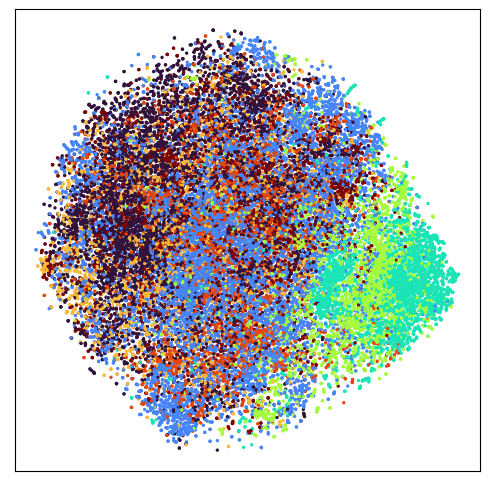

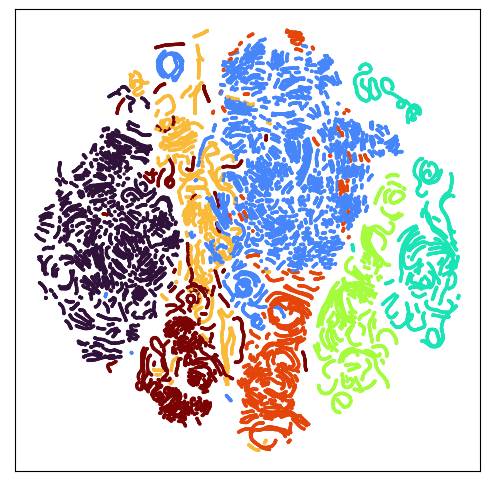

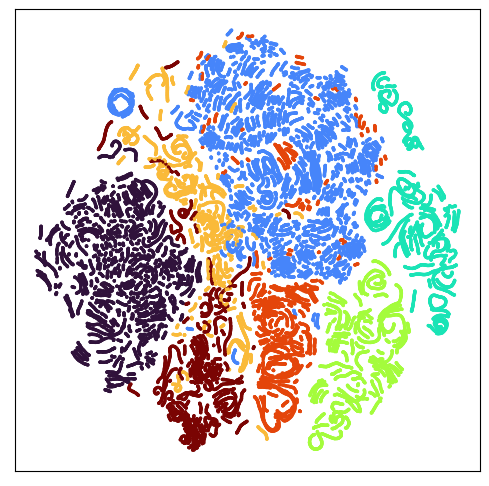

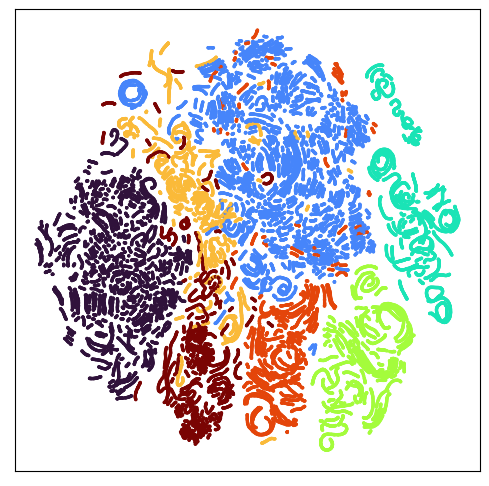

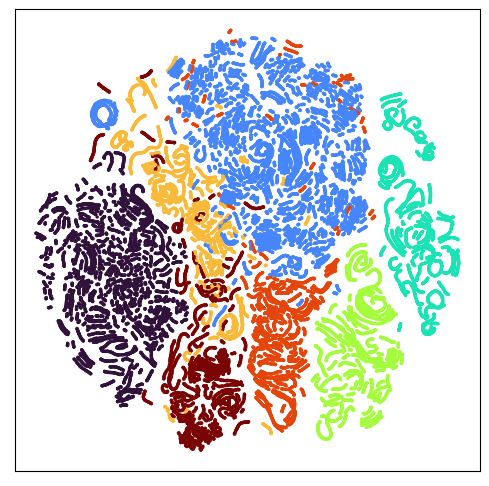

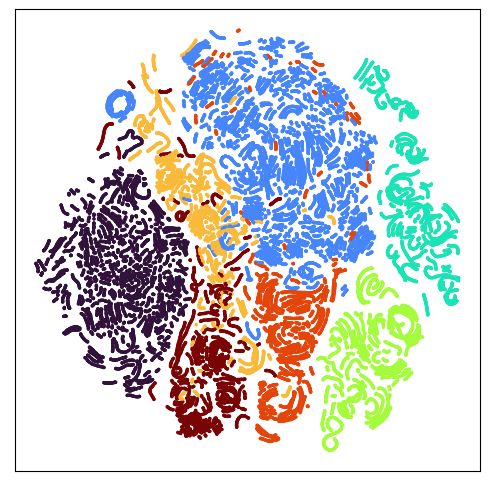

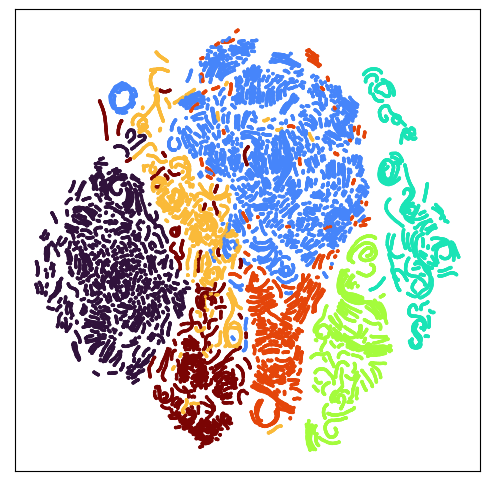

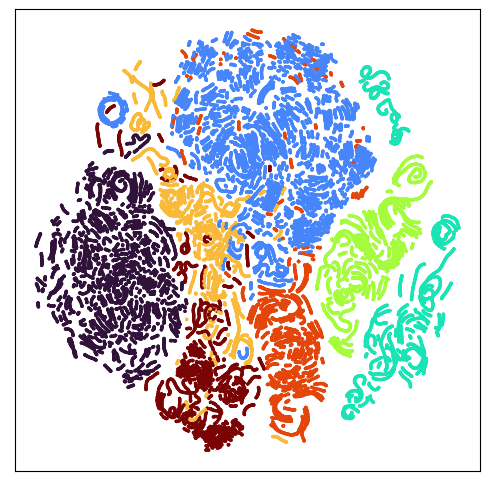

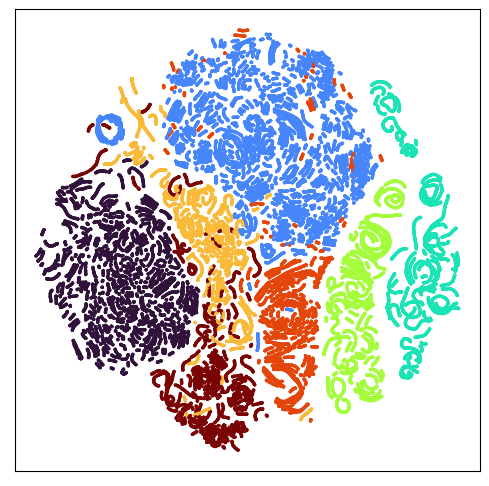

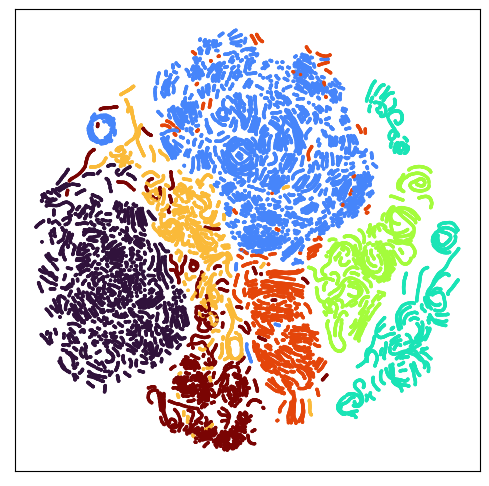

In [12]:
for epoch in range(1, epoch_num + 1):

    if (epoch - 1) % 2 == 0:
        encoder.eval()

        test_trues = []
        vib_feat = []
        reconstruct_spec = []

        with torch.no_grad():
            for i, (img, label) in enumerate(train_dataloader):
                img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
                img = img.to(device)
                label = label.to(device)

                feat, i_1, i_2 = encoder(img)

                test_trues.extend(label.detach().cpu().numpy())
                vib_feat.extend(feat.detach().cpu().numpy())
        
        tsne = TSNE(n_components=2, init='pca')
        X = np.array(vib_feat)
        X_tsne = tsne.fit_transform(X)
        x_min, x_max = X_tsne.min(0), X_tsne.max(0)
        X_norm = (X_tsne - x_min) / (x_max - x_min)
        plt.figure(figsize=(6,6))
        plt.scatter(X_norm[:,0], X_norm[:,1], s=2, c=test_trues, cmap='turbo')
        plt.xticks([])
        plt.yticks([])
        plt.savefig('training_vis/epoch' + str(epoch - 1) + '.png')
        plt.show()

    encoder.train(mode=True)
    decoder.train(mode=True)
    classifier.train(mode=True)

    correct = torch.zeros(1).squeeze().to(device)
    total = torch.zeros(1).squeeze().to(device)

    for i, (img, label) in enumerate(train_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)
        label = label.to(device)

        feat, i_1, i_2 = encoder(img)
        pred_img = decoder(feat, i_1, i_2)
        pred_label = classifier(feat)

        classify_loss = crossentropy(pred_label, label)
        autoencoder_loss = mse(pred_img, img)
        loss = classify_loss + autoencoder_loss

        prediction = torch.argmax(pred_label, 1)
        correct += (prediction == label).sum().float()
        total += len(label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step(loss)

    # print('Epoch: ', epoch, 'Accuracy: ', (correct/total).cpu().detach().data.numpy(), 'Autoencoder Loss: ', autoencoder_loss.item())